<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

运行SpinalHDL代码之前，务必加载SpinalHDL的库 
（**注**：*第一次运行时需要下载库，可能会有点慢，请耐心等待*）

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## 总线
### apb

In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.misc._

class Top extends Component{
    val apb = slave(Apb3(Apb3Config(5,32,2)))
    val slv = Apb3SlaveFactory(apb,1)   
    //val regfile = Vec(Reg(Bits(32 bits)),32)
    val regfile = Mem(Bits(32 bits),32)
    when(slv.doRead){
        apb.PRDATA := regfile(slv.readAddress).allowPruning()
    }
    when(slv.doWrite){
        regfile(slv.writeAddress) := apb.PWDATA
    }
}

showRtl(new Top)

寄存器读写

In [ ]:

class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val  k = Reg(UInt(8 bits)) init 0
    val  f = Reg(UInt(4 bits)) init 0
    val  c = Reg(UInt(2 bits)) init 0

 slv.readAndWrite(regs(0),address=0)
 slv.write(k,address= 4,bitOffset=0)    
 slv.write(f,address= 4,bitOffset=8)   
 slv.write(c,address= 4,bitOffset=12)
 slv.read (c##f##k,address= 4)
 slv.readAndWrite(regs(1),address= 8 )
 slv.readAndWrite(regs(2),address= 12 )
 slv.readAndWrite(regs(3),address= 16 )
//slv.driveAndRead(regs(1),address=4)
//slv.write(regs(2),address=8)
//slv.readAndWrite(regs(3),address=12)
//slv.onRead( address=16)(Reg(4) :=0 )
//slv.onWrite( address=20)(Reg(4) :=0xff)   
//val a = slv.isWriting( address=24)   
//val b = slv.isReading( address=28)  
}

showRtl(new Top)

In [ ]:
class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val a,b,c = Reg(UInt(10 bits)) init 0 
    val clc = in Bool()
    val en2,en3= RegInit(False)
     
    //slv.write(address = 0,(0,a),(10,b),(20,c))
    //slv.read(address = 0,(0,a),(10,b),(20,c))
    
    val en = Reg(Bool()) init False setWhen(slv.isWriting(4))
    slv.onWrite(8)( en.clearWhen(clc) )
    slv.setOnSet(en2,12,3)
    slv.clearOnSet(en3,12,4)
}

showRtl(new Top)

Mem读写

In [ ]:
class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    (0 until 8).map(i=>slv.readAndWrite(regs(i),address= i * 4 ))
}

showRtl(new Top)

## AXI 

In [ ]:
import spinal.lib.bus.amba3.ahblite._

In [ ]:

class Top extends Component{
    val ahb = slave(AhbLite3(AhbLite3Config(8,32)))
    val slv = new AhbLite3SlaveFactory(ahb)
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    (0 until 8).map(i=>slv.readAndWrite(regs(i),address= i * 4 ))
    
    val a,b,c = Reg(UInt(10 bits)) init 0 
    slv.write(address = 9*4,(0,a),(10,b),(20,c))
    slv.read(address = 9*4,(0,a),(10,b),(20,c))
    val clc = in Bool()
    val en2,en3= RegInit(False)
    val en = Reg(Bool()) init False setWhen(slv.isWriting(10*4))
    slv.onWrite(8)( en.clearWhen(clc) )
    //slv.setOnSet(en2,0,3)
    //slv.clearOnSet(en3,11*4 )
}

showRtl(new Top)

In [ ]:
class Top extends Component{
    val ahb = slave(AhbLite3(AhbLite3Config(8,32)))
    val slv = new AhbLite3SlaveFactory(ahb)
    //val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val regs = Mem(UInt(32 bits),8)
     
    //slv.write(regs(0),0)
    //slv.write(regs(1),4)
    //slv.write(regs(2),8)
    (0 until 8).map(i=>slv.write(regs(i),address= i * 4 ))
    
     
}

showRtl(new Top)

## 地址分配
### Bram-bus地址分配

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top extends Component{    
    val din  = slave(BRAM(BRAMConfig(32,16)))
    val do1  = master(BRAM(BRAMConfig(32, 8)))
    val do2  = master(BRAM(BRAMConfig(32,12)))    
    val do3  = master(BRAM(BRAMConfig(32,12)))      
    val do4  = master(BRAM(BRAMConfig(32,2)))
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00,    64 ),
                                    do2 ->  (0x1000,1 MiB),                                   
                                    do3 ->  (0x2000,3 MiB),                                   
                                    do4 ->  (0x3000,2)))  
}
showRtl(new Top)

BRAM的地址分配 ，数据位宽是8bit 还是32bit/64bit， 地址从0开始计数，没有问题   
只有在自动分配时需要根据数据位宽来从低n比特开始增加。   
 /** Address incrementation used by the read and write multi words registers */  
  def wordAddressInc: Int = busDataWidth / 8

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top(w: Int) extends Component{    
    val din  = slave(BRAM(BRAMConfig(w,12)))
    val do1  = master(BRAM(BRAMConfig(w,10)))
    val do2  = master(BRAM(BRAMConfig(w,10))) 
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00000,1 KiB),
                                    do2 ->  (0x10000,3 KiB))) 
}
showRtl(new Top(8))

### Ahb地址分配

#### Apb3Decoder 仅仅会译码出多个PSEL信号
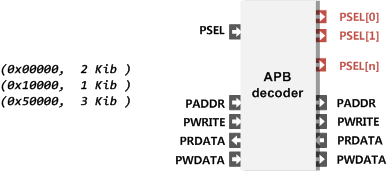

In [ ]:
showRtl(new Apb3Decoder(Apb3Config(16,32),List((0x00,20),
                                               (0x1000,1 KiB),
                                               (0x2000,1 KiB))))

#### ApbRouter   
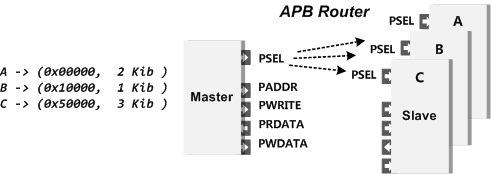

In [ ]:
showRtl(new Apb3Router(Apb3Config(16,32,3)))

In [ ]:
import spinal.lib.bus.amba3.apb._

class Top extends Component{    
    val din  =  slave(Apb3(Apb3Config(16,32)))
    val do1  = master(Apb3(Apb3Config( 8,32)))
    val do2  = master(Apb3(Apb3Config(12,32)))    
    val do3  = master(Apb3(Apb3Config(12,32)))      
    val do4  = master(Apb3(Apb3Config( 2,32)))
    
val mux = Apb3Decoder(master = din, 
                      slaves = List(do1 ->  (0x0000,  64 ),
                                    do2 ->  (0x1000,1 KiB),                                   
                                    do3 ->  (0x2000,3 KiB),                                   
                                    do4 ->  (0x3000,  32 )))
}
showRtl(new Top)                  

**注意**：  
对于apply多个匹配的情况，隐式转换需要制定参数名，否则隐式转换不成功
```scala
val mux = Apb3Decoder(Apb3Config(16,32),
                      List((0x00000,64),(0x10000,64)))

implicit def implicitTuple1(that:(Int, Int)):SizeMapping = SizeMapping(that._1,that._2)
```
会报错，原因是Apb3Decoder有多个模式匹配项(scala 隐式转换不能嵌套)，不知道匹配哪一个，隐式转换不成功
```scala
object Apb3Decoder{
  def apply(inputConfig: Apb3Config, decodings: Seq[SizeMapping]): Apb3Decoder={...}
  def apply(master: Apb3, slaves: Seq[(Apb3, SizeMapping)]): Apb3Decoder = {...}
}
```
正确的做法是，指定参数名（给编译器信息）

```scala
val mux = Apb3Decoder(inputConfig = Apb3Config(16,32),
                      decodings = List((0x00000,64),(0x10000,64)))
```

**对于只有一个apply的模式匹配，可以省略参数名**

### AXI crossBar
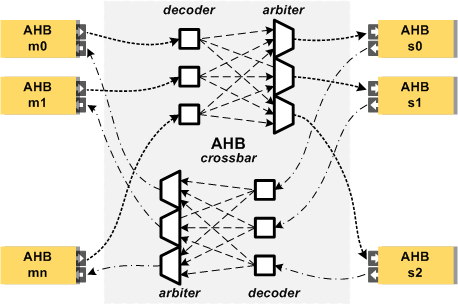

In [ ]:
import spinal.lib.bus.amba4.axi._ 

showRtl(Axi4SharedDecoder(
  axiConfig = Axi4Config(16,32,4),
  readDecodings = List((0x0000, 64    ),
                       (0x1000, 1 KiB ),
                       (0x2000, 3 KiB )),
  writeDecodings = List((0x1000, 3 KiB ),
                        (0x2000, 3 KiB )), 
  sharedDecodings = List((0x0000, 2 KiB),
                         (0x5000, 1 KiB) )
))

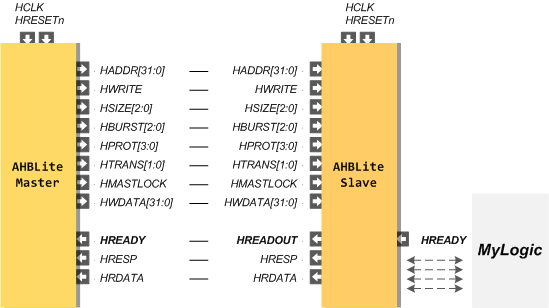

#### AhbToApb3 Bridge


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba3.ahblite._

class Top(ahbConfig:AhbLite3Config, apbConfig:Apb3Config) extends Component{
    val ahb = slave(AhbLite3(ahbConfig))
    val apb = master(Apb3(apbConfig))
    val bridge = AhbLite3ToApb3Bridge(ahbConfig,apbConfig)
    ahb <> bridge.io.ahb
    apb <> bridge.io.apb
}

showRtl(new Top(AhbLite3Config(16,32),Apb3Config(16,32)))

In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba4.axi._

class Top(aw: Int,dw: Int,iw: Int) extends Component{
  val axi = slave(Axi4Shared(Axi4Config(aw,dw,iw)))
  val apb = master(Apb3(Apb3Config(aw,dw,iw)))
  val bridge = Axi4SharedToApb3Bridge(aw,dw,iw)
  axi <> bridge.io.axi
  apb <> bridge.io.apb
}

showRtl(new Top(20,32,2))